In [12]:
import pandas as pd
import pdb
import numpy as np
import itertools
from snakemake.io import expand
import yaml
import os
import sys
import pathlib
import pyranges as pr
import cerberus 
import swan_vis as swan
import met_brewer
import seaborn as sns

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from utils import *
from sm_utils import *
from humanized_utils import *

In [2]:
config_file = 'config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
swan_file = expand(config['swan']['swan_graph'], 
                   analysis='hABKI_Swe_IB_HET_WT')[0]


In [6]:
sg = swan.read(swan_file)
obs = sg.adata.obs.copy(deep=True)

Read in graph from data/swan/hABKI_Swe_IB_HET_WT/swan_graph.p


In [7]:
# get unique genotypes, timepoints, tissues, etc
genotypes = obs.genotype.unique()
sex = obs.sex.unique()
ages = obs.age.unique()
tissues = obs.tissue.unique()

In [8]:
print(genotypes)
print(sex)
print(ages)
print(tissues)

['hABKI_Swe_IB_HET' 'hABKI_Swe_IB_WT']
['F' 'M']
['8_weeks']
['HC']


{0: '#2b9b81', 1: '#fe9b00', 2: '#f4c40f', 3: '#fbe183', 4: '#633372', 5: '#9b3441', 6: '#e6a2a6', 7: '#92c051', 8: '#1f6e9c', 9: '#9f5691', 10: '#e87b89'}


<AxesSubplot:xlabel='num'>

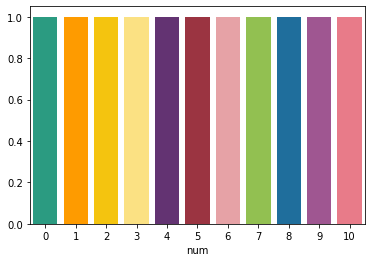

In [13]:
df = pd.DataFrame()
df['color'] = met_brewer.met_brew("Signac", n=11, brew_type="discrete")
df['num'] = df.index.tolist()
cmap = dict([(num, color) for num, color in zip(df.num.tolist(), df.color.tolist())])
print(cmap)
sns.barplot(df, y=[1 for i in range(len(df.index))], x='num', palette=cmap, saturation=1)

In [14]:
g_cmap = {'hABKI_Swe_IB_HET': cmap[1],
          'hABKI_Swe_IB_WT': cmap[2]}
s_cmap = {'M': cmap[3],
          'F': cmap[7]}
t_cmap = {'HC': cmap[10]}          

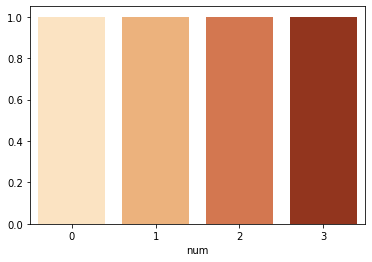

In [15]:
df = pd.DataFrame()
df['color'] = met_brewer.met_brew("OKeeffe2", n=4, brew_type="continuous")
df['num'] = df.index.tolist()
cmap = dict([(num, color) for num, color in zip(df.num.tolist(), df.color.tolist())])
sns.barplot(df, y=[1 for i in range(len(df.index))], x='num', palette=cmap, saturation=1)
order = ['8_weeks', 
         '10_weeks',
         '4_months',
         '18_months']
a_cmap = dict()
for i,t in enumerate(order):
    a_cmap[t] = cmap[i]

In [16]:
sg.set_metadata_colors('genotype', g_cmap)
sg.set_metadata_colors('tissue', t_cmap)
sg.set_metadata_colors('sex', s_cmap)
sg.set_metadata_colors('age', a_cmap)

In [29]:
import glob
# loc = 'data/swan/hABKI_Swe_IB_HET_WT/*genotype_sex_du_*.tsv'
loc = 'data/swan/hABKI_Swe_IB_HET_WT/*genotype_du*.tsv'
du_df = pd.DataFrame()
for f in glob.glob(loc):
    print(f)
    feat = f.rsplit('_')[-1].split('.')[0]
    cond1 = f.rsplit('/')[-1].split('_vs_')[0]
    cond2 = f.rsplit('/')[-1].split('_vs_')[1].split('_genotype')[0]
    # print(feat)
    # print(cond1)
    # print(cond2)
    temp = pd.read_csv(f, sep='\t')
    temp['feat'] = feat
    temp['cond1'] = cond1
    temp['cond2'] = cond2
    du_df = pd.concat([du_df, temp], axis=0)

data/swan/hABKI_Swe_IB_HET_WT/hABKI_Swe_IB_HET_vs_hABKI_Swe_IB_WT_genotype_du_tss.tsv
data/swan/hABKI_Swe_IB_HET_WT/hABKI_Swe_IB_HET_vs_hABKI_Swe_IB_WT_genotype_du_iso.tsv
data/swan/hABKI_Swe_IB_HET_WT/hABKI_Swe_IB_HET_vs_hABKI_Swe_IB_WT_genotype_du_tes.tsv


In [33]:
# filter on pval and dpi
adj_p_thresh = 0.05
dpi_thresh = 20
du_df = du_df.loc[(du_df.adj_p_val<=adj_p_thresh)&(du_df.dpi>=dpi_thresh)]
du_df.head()

,Unnamed: 0,gid,p_val,dpi,pos_iso_1,pos_iso_2,pos_iso_1_dpi,pos_iso_2_dpi,neg_iso_1,neg_iso_2,neg_iso_1_dpi,neg_iso_2_dpi,adj_p_val,gname,feat,cond1,cond2
2,2,ENSMUSG00000000093,1.388435e-06,40.845074,ENSMUSG00000000093_1,NaN,40.845074,NaN,ENSMUSG00000000093_2,NaN,-40.845070,NaN,4.367816e-06,Tbx2,tss,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT
3,3,ENSMUSG00000000125,5.169985e-04,48.148148,ENSMUSG00000000125_2,NaN,48.148148,NaN,ENSMUSG00000000125_3,NaN,-48.148148,NaN,1.106542e-03,Wnt3,tss,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT
6,6,ENSMUSG00000000142,1.806651e-09,24.166666,ENSMUSG00000000142_3,NaN,24.166666,NaN,ENSMUSG00000000142_1,NaN,-24.166664,NaN,7.653674e-09,Axin2,tss,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT
9,9,ENSMUSG00000000215,1.636984e-04,43.478264,ENSMUSG00000000215_3,NaN,43.478260,NaN,ENSMUSG00000000215_2,NaN,-43.478264,NaN,3.840663e-04,Ins2,tss,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT
13,13,ENSMUSG00000000266,1.591154e-09,21.857925,ENSMUSG00000000266_3,NaN,21.857925,NaN,ENSMUSG00000000266_2,ENSMUSG00000000266_5,-15.846994,-6.010929,6.778117e-09,Mid2,tss,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT


In [34]:
du_df[['gid', 'feat']].groupby('feat').count()

,gid
feat,
iso,2642
tes,1843
tss,833


In [35]:
du_df = du_df.sort_values(by='dpi', ascending=False)
du_df.loc[du_df.feat=='iso'].head()

,Unnamed: 0,gid,p_val,dpi,pos_iso_1,pos_iso_2,pos_iso_1_dpi,pos_iso_2_dpi,neg_iso_1,neg_iso_2,neg_iso_1_dpi,neg_iso_2_dpi,adj_p_val,gname,feat,cond1,cond2
5719,5719,ENSMUSG00000032280,9.182448e-21,100.000006,"ENSMUSG00000032280[12,21,5]","ENSMUSG00000032280[12,21,1]",73.015877,26.984129,"ENSMUSG00000032280[2,4,5]","ENSMUSG00000032280[1,6,5]",-31.914892,-14.893617,4.185953e-20,Tle3,iso,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT
4742,4742,ENSMUSG00000029313,2.269842e-14,100.000005,"ENSMUSG00000029313[2,8,8]","ENSMUSG00000029313[2,8,5]",62.790699,30.232557,"ENSMUSG00000029313[2,8,10]","ENSMUSG00000029313[2,9,9]",-88.888893,-11.111112,7.622302e-14,Aff1,iso,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT
8897,8897,ENSMUSG00000051029,8.423464e-12,100.000004,"ENSMUSG00000051029[2,3,4]",NaN,100.000000,NaN,"ENSMUSG00000051029[2,4,1]","ENSMUSG00000051029[2,3,1]",-55.555557,-44.444447,2.413716e-11,Serpinb1b,iso,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT
7454,7454,ENSMUSG00000039834,5.364245e-39,100.000004,"ENSMUSG00000039834[1,6,1]","ENSMUSG00000039834[4,6,1]",50.549454,49.450550,"ENSMUSG00000039834[1,6,3]","ENSMUSG00000039834[4,7,1]",-92.222221,-7.777778,4.186998e-38,Zfp335,iso,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT
9407,9407,ENSMUSG00000056763,3.442477e-14,100.000004,"ENSMUSG00000056763[18,7,24]",NaN,100.000000,NaN,"ENSMUSG00000056763[2,3,4]","ENSMUSG00000056763[2,3,3]",-55.555557,-44.444447,1.144793e-13,Cspp1,iso,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT


In [41]:
def plot_report(sg, gene):
    study = sg.adata.obs.study.tolist()[0]
    sg.gen_report(gene,
                  f'figures/{gene}_{study}',
                  novelty=True,
                  cmap='viridis',
                  indicate_novel=True,
                  transcript_col='tname',
                  metadata_cols=['genotype', 'sex', 'tissue', 'age'],
                  datasets={'genotype': ['hABKI_Swe_IB_HET', 'hABKI_Swe_IB_WT']})
    sg.gen_report(gene,
                  f'figures/{gene}_{study}',
                  novelty=True,
                  cmap='viridis',
                  transcript_col='tname',
                  display_numbers=True,
                  browser=True,
                  layer='pi',
                  metadata_cols=['genotype', 'sex', 'tissue', 'age'],
                  datasets={'genotype': ['hABKI_Swe_IB_HET', 'hABKI_Swe_IB_WT']})

In [43]:
plot_report(sg, 'Tle3')


Plotting transcripts for ENSMUSG00000032280
Saving transcript path graph for ENSMUSG00000032280[12,21,5] as figures/Tle3_ad008_novel_ENSMUSG00000032280[12,21,5]_path.png
Saving transcript path graph for ENSMUSG00000032280[12,21,1] as figures/Tle3_ad008_novel_ENSMUSG00000032280[12,21,1]_path.png
Saving transcript path graph for ENSMUSG00000032280[2,4,5] as figures/Tle3_ad008_novel_ENSMUSG00000032280[2,4,5]_path.png
Saving transcript path graph for ENSMUSG00000032280[4,4,5] as figures/Tle3_ad008_novel_ENSMUSG00000032280[4,4,5]_path.png
Saving transcript path graph for ENSMUSG00000032280[2,4,1] as figures/Tle3_ad008_novel_ENSMUSG00000032280[2,4,1]_path.png
Saving transcript path graph for ENSMUSG00000032280[1,6,5] as figures/Tle3_ad008_novel_ENSMUSG00000032280[1,6,5]_path.png
Saving transcript path graph for ENSMUSG00000032280[2,6,5] as figures/Tle3_ad008_novel_ENSMUSG00000032280[2,6,5]_path.png
Saving transcript path graph for ENSMUSG00000032280[2,6,1] as figures/Tle3_ad008_novel_ENSMUS

In [44]:
plot_report(sg, 'Serpinb1b')


Plotting transcripts for ENSMUSG00000051029
Saving transcript path graph for ENSMUSG00000051029[2,3,4] as figures/Serpinb1b_ad008_novel_ENSMUSG00000051029[2,3,4]_path.png
Saving transcript path graph for ENSMUSG00000051029[2,4,1] as figures/Serpinb1b_ad008_novel_ENSMUSG00000051029[2,4,1]_path.png
Saving transcript path graph for ENSMUSG00000051029[2,3,1] as figures/Serpinb1b_ad008_novel_ENSMUSG00000051029[2,3,1]_path.png
Generating report for ENSMUSG00000051029

Plotting transcripts for ENSMUSG00000051029
Saving transcript path graph for ENSMUSG00000051029[2,3,4] as figures/Serpinb1b_ad008_browser_ENSMUSG00000051029[2,3,4]_path.png
Saving transcript path graph for ENSMUSG00000051029[2,4,1] as figures/Serpinb1b_ad008_browser_ENSMUSG00000051029[2,4,1]_path.png
Saving transcript path graph for ENSMUSG00000051029[2,3,1] as figures/Serpinb1b_ad008_browser_ENSMUSG00000051029[2,3,1]_path.png
Generating report for ENSMUSG00000051029
